In [9]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate, XGate

from qiskit_algorithms import optimizers
from qiskit.primitives import Estimator

from scipy.optimize import minimize

# import matplotlib.pyplot as plt

from qiskit import *
from qiskit.visualization import *
# from qiskit_aer import Aer

from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper

# Para cargar lo necesario
import pickle

In [10]:
# Cargar el hamiltoniano desde el archivo
with open("hamiltonian.pkl", "rb") as f:
    hamiltonian = pickle.load(f)

# Verifica que se ha cargado correctamente
print(hamiltonian)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.80718366+0.j,  0.17374013+0.j, -0.23047453+0.j,  0.17374013+0.j,
 -0.23047453+0.j,  0.12148839+0.j,  0.16940471+0.j,  0.1665822 +0.j,
  0.04509381+0.j,  0.04509381+0.j,  0.04509381+0.j,  0.04509381+0.j,
  0.1665822 +0.j,  0.17510657+0.j,  0.12148839+0.j])


Iteración 1: Energía = -0.7230246779377171
Iteración 2: Energía = -0.6109992223290858
Iteración 3: Energía = -0.6413129895031093
Iteración 4: Energía = -0.46460798022873645
Iteración 5: Energía = -0.7747998260801792
Iteración 6: Energía = -0.7941323274087106
Iteración 7: Energía = -0.8709994445757693
Iteración 8: Energía = -0.9351309274180974
Iteración 9: Energía = -1.0450739637234208
Iteración 10: Energía = -1.0784528591933462
Iteración 11: Energía = -1.0660304905278974
Iteración 12: Energía = -1.0771944426059523
Iteración 13: Energía = -1.2394874064898946
Iteración 14: Energía = -1.224829282509598
Iteración 15: Energía = -1.202668221573257
Iteración 16: Energía = -1.1714189916066726
Iteración 17: Energía = -1.2077996620768496
Iteración 18: Energía = -1.2386281142049036
Iteración 19: Energía = -1.237796740128834
Iteración 20: Energía = -1.1699759070159468
Iteración 21: Energía = -1.1563104490132732
Iteración 22: Energía = -1.0991070960334586
Iteración 23: Energía = -1.1518487784474043

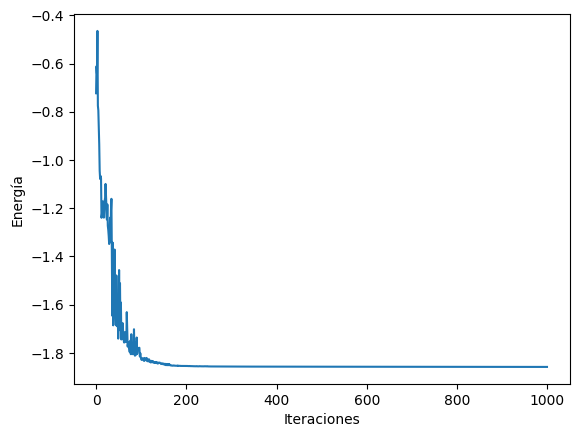

In [11]:
# Simulador local
simulator = Aer.get_backend('qasm_simulator')

# Ansatz de 4 qubits
theta = Parameter("θ")
ansatz = NLocal(
    num_qubits=4,
    rotation_blocks=[RXGate(theta), CRZGate(theta)],  # Keep rotation blocks
    entanglement_blocks=CCXGate(),
    entanglement=[[0, 1, 2], [1, 2, 3]],  # Define entanglement pattern
    reps=2,
    insert_barriers=True,
)

num_params = ansatz.num_parameters

# Inicialización del parámetro
x0 = 2 * np.pi * np.random.random(num_params)

# Diccionario para almacenar la evolución del costo
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

# Función de coste
def cost_func(params, ansatz, hamiltonian, estimator):
    job = estimator.run([ansatz], [hamiltonian], [params])
    result = job.result()
    energy = result.values[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)

    print(f"Iteración {cost_history_dict['iters']}: Energía = {energy}")

    return energy

# Creamos el estimador para el simulador
backend=simulator
estimator = Estimator()

# Ejecutamos la optimización
res = minimize(
    cost_func,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method="COBYLA",
)

# Resultado final
print("Parámetros óptimos:", res.x)
print("Energía mínima encontrada:", res.fun)

# Graficar evolución del costo
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iteraciones")
ax.set_ylabel("Energía")
plt.show()

In [4]:
# Cargar nuclear_repulsion desde el archivo
with open("nuclear_repulsion.pkl", "rb") as f:
    nuclear_repulsion = pickle.load(f)

print(f"Energía nuclear: {nuclear_repulsion}")
energy = res.fun + nuclear_repulsion
print(f"Energía total: {energy}")

Energía nuclear: 0.7298996012689656
Energía total: -1.1294179710793417


c:\Anaconda\envs\qiskitTFM\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


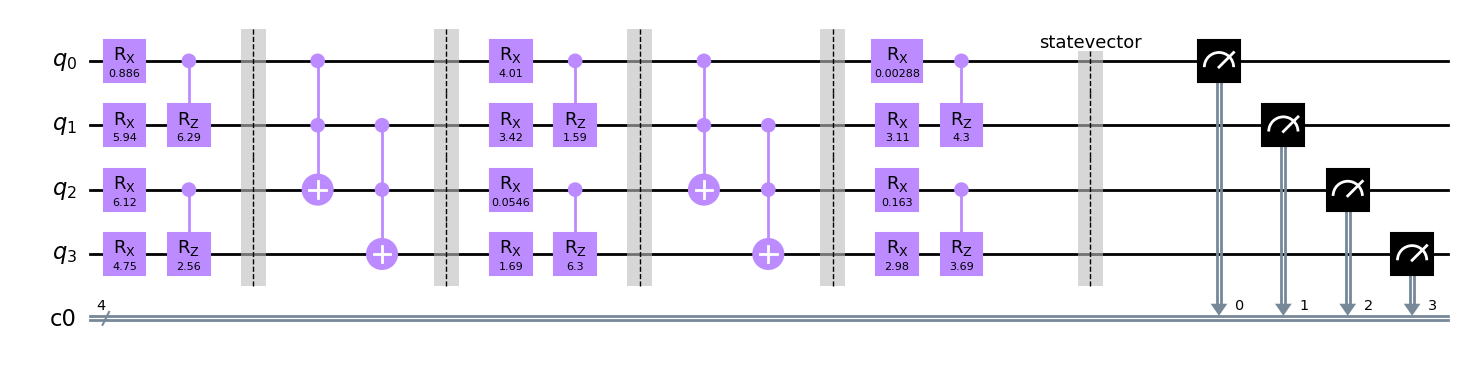

In [5]:
# Estado cuántico

qc_bound = ansatz.assign_parameters({list(ansatz.parameters)[i]: res.x[i] for i in range(len(res.x))}) # Asignamos los parámetros al circuito

c_reg = ClassicalRegister(ansatz.num_qubits) # Añadimos un bit clásico a qc_bound
qc_bound.add_register(c_reg)

qc_bound.save_statevector() # Guardamos el estado antes de la medida

qc_bound.measure(range(4),range(4)) # Medimos

qc_bound.decompose().draw("mpl") # Dibujamos

Statevector([-9.65418914e-04+9.80560615e-05j,
              5.17985454e-03-3.91315113e-03j,
              4.47263797e-05-1.70174011e-03j,
             -8.90156159e-04-6.69557689e-04j,
              5.79328115e-04+1.90760429e-03j,
              9.93497413e-01-5.30777409e-02j,
              1.85454111e-02+6.35850032e-02j,
              1.59896922e-02+2.72990297e-02j,
              1.16477732e-04+7.66893793e-04j,
             -5.01735105e-03-3.90541732e-03j,
             -6.60257696e-02+1.68994671e-03j,
              2.07112531e-03+1.97091518e-04j,
             -9.23190796e-03-1.64549643e-03j,
              1.55059713e-03+1.08736132e-03j,
              1.52828944e-03+3.82380764e-04j,
             -1.43143131e-02-1.84374628e-04j],
            dims=(2, 2, 2, 2))


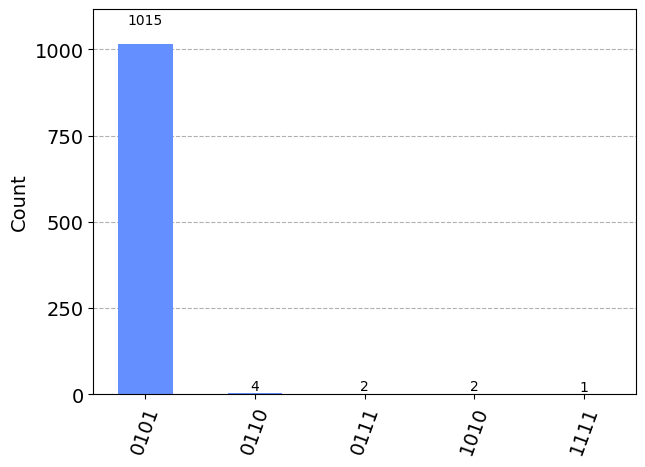

In [8]:
# Simulamos

sim = Aer.get_backend('qasm_simulator')
my_circuit = transpile(qc_bound, sim)
job = sim.run(my_circuit)
result = job.result()

sv = result.get_statevector()
print(sv)

counts = result.get_counts()
plot_histogram(counts)